In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import math

%matplotlib inline

## 1. Define Convolution Operation

In [2]:
def to_rgb_first_dim(img):
    result = img.swapaxes(0, 2)
    result = result.swapaxes(1, 2)
    return result

In [3]:
def to_rgb_last_dim(img):
    result = img.swapaxes(0, 2)
    result = result.swapaxes(0, 1)
    return result

In [4]:
def map_forward(volume, map_filter, map_func, padding=0, stride=1, padding_mode='constant'):
    padded_volume = volume
    if not padding == 0:
        pad_kwargs = {
            'array': padded_volume,
            'pad_width': ((0, 0), (padding, padding), (padding, padding)),
            'mode': padding_mode
        }
        if padding_mode == 'constant':
            pad_kwargs['constant_values'] = 0
        padded_volume = np.lib.pad(**pad_kwargs)

    filter_height = map_filter.shape[1]
    filter_width = map_filter.shape[2]
    volume_channel = padded_volume.shape[0]
    volume_height = padded_volume.shape[1]
    volume_width = padded_volume.shape[2]
    result_height = math.ceil((volume_height - filter_height) // stride + 1)
    result_width = math.ceil((volume_width - filter_width) // stride + 1)
    
    result = np.zeros(shape=(1, result_height, result_width), dtype=np.float32)
    for start_y in np.arange(result_height):
        result_y = start_y
        start_y *= stride
        end_y = start_y + filter_height
        if end_y >= volume_height:
            continue
        for start_x in np.arange(result_width):
            result_x = start_x
            start_x *= stride
            end_x = start_x + filter_width
            if end_x >= volume_width or result_x >= result_width or result_y >= result_height:
                continue
            multiplied_region = padded_volume[:, start_y:end_y, start_x:end_x] * map_filter
            result[:, result_y, result_x] = map_func(
                multiplied_region,
                keepdims=True
            ).flatten()

    return result

In [5]:
def conv_forward(volume, conv_filter, padding=0, stride=1, padding_mode='constant'):
    return map_forward(volume, conv_filter, map_func=np.sum, padding=padding, stride=stride, padding_mode=padding_mode)

In [6]:
def pooling_forward(volume, pooling_size, padding=0, stride=1, padding_mode='constant', pooling_mode='max'):
    pooling_filter = np.ones(shape=(1, pooling_size, pooling_size))
    map_func = np.sum
    if pooling_mode == 'max':
        map_func = np.max
    elif pooling_mode == 'average':
        map_func = np.average
    return map_forward(volume, pooling_filter, map_func=map_func, padding=padding, stride=stride, padding_mode=padding_mode)

## 2. Load Image and Apply Convolution

In [7]:
def show_conv_b4_after(img_path, conv_filter, pooling_size=None, pooling_stride=1, padding=0, stride=1):
    img = Image.open(img_path)
    resizing_scale = 3
    img.thumbnail((img.size[1]//resizing_scale, img.size[0]//resizing_scale), Image.ANTIALIAS)
    img = np.asarray(img)
    conv_result = conv_forward(
        to_rgb_first_dim(img),
        conv_filter,
        padding=padding,
        stride=stride
    )
    if pooling_size is not None:
        pool_result = pooling_forward(conv_result, pooling_size, stride=pooling_stride)
        pool_result = to_rgb_last_dim(pool_result)
        pool_result = pool_result.reshape(pool_result.shape[0], pool_result.shape[1])
    conv_result = to_rgb_last_dim(conv_result)
    conv_result = conv_result.reshape(conv_result.shape[0], conv_result.shape[1])
    
    plt_width = 16
    plt_width_height = plt_width/img.shape[1] * img.shape[0]
    plt.figure(figsize=(plt_width, plt_width_height))
    if pooling_size is None:
        plt.subplot(121)
    else:
        plt.subplot(221)
    plt.title('Original Image')
    plt.imshow(img)
    if pooling_size is None:
        plt.subplot(122)
    else:
        plt.subplot(222)
    plt.title('Convolution')
    plt.imshow(conv_result, cmap='gray')
    if pooling_size is not None:
        plt.subplot(223)
        plt.title('Max Pool')
        plt.imshow(pool_result, cmap='gray')

In [8]:
filter_size = 8

In [9]:
# Vertical edge detector

conv_filter_vertical_tmp = np.zeros(shape=(1, filter_size, filter_size), dtype=np.float32)
start_idx = filter_size // 4
mid_idx = filter_size // 2
end_idx = int(mid_idx * 2 - start_idx)
conv_filter_vertical_tmp[:, :, start_idx:mid_idx] = 1
conv_filter_vertical_tmp[:, :, mid_idx:end_idx] = -1
conv_filter_vertical = np.repeat(conv_filter_vertical_tmp, 3, axis=0)

In [10]:
# Horizontal edge detector

conv_filter_horizontal_tmp = conv_filter_vertical_tmp.copy()
conv_filter_horizontal_tmp[0] = conv_filter_horizontal_tmp[0].T
conv_filter_horizontal = np.repeat(conv_filter_horizontal_tmp, 3, axis=0)

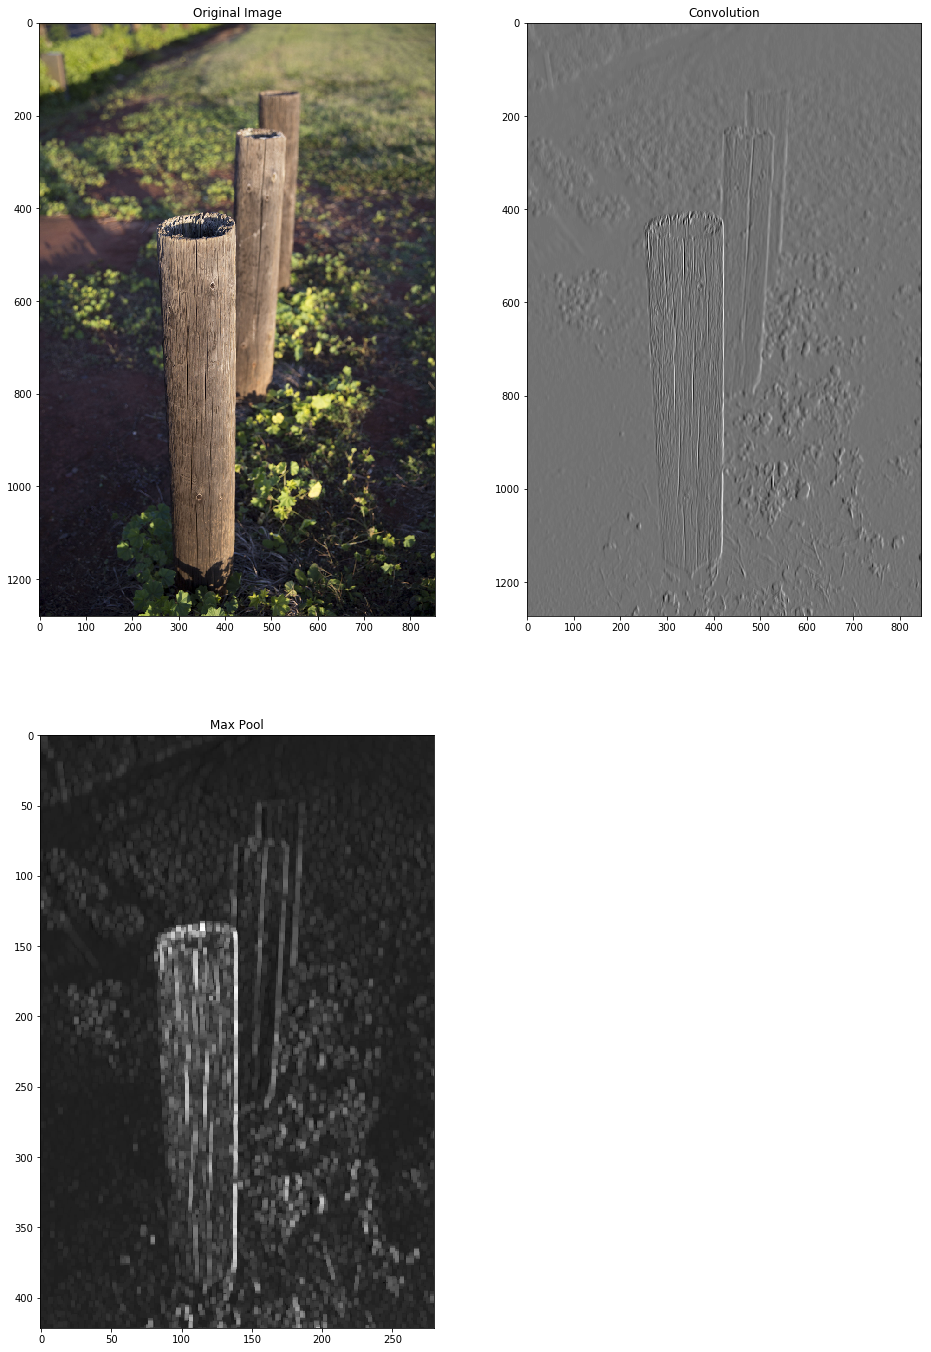

In [11]:
show_conv_b4_after('data/hawaii_1.jpg', conv_filter_vertical, pooling_size=filter_size, pooling_stride=3)

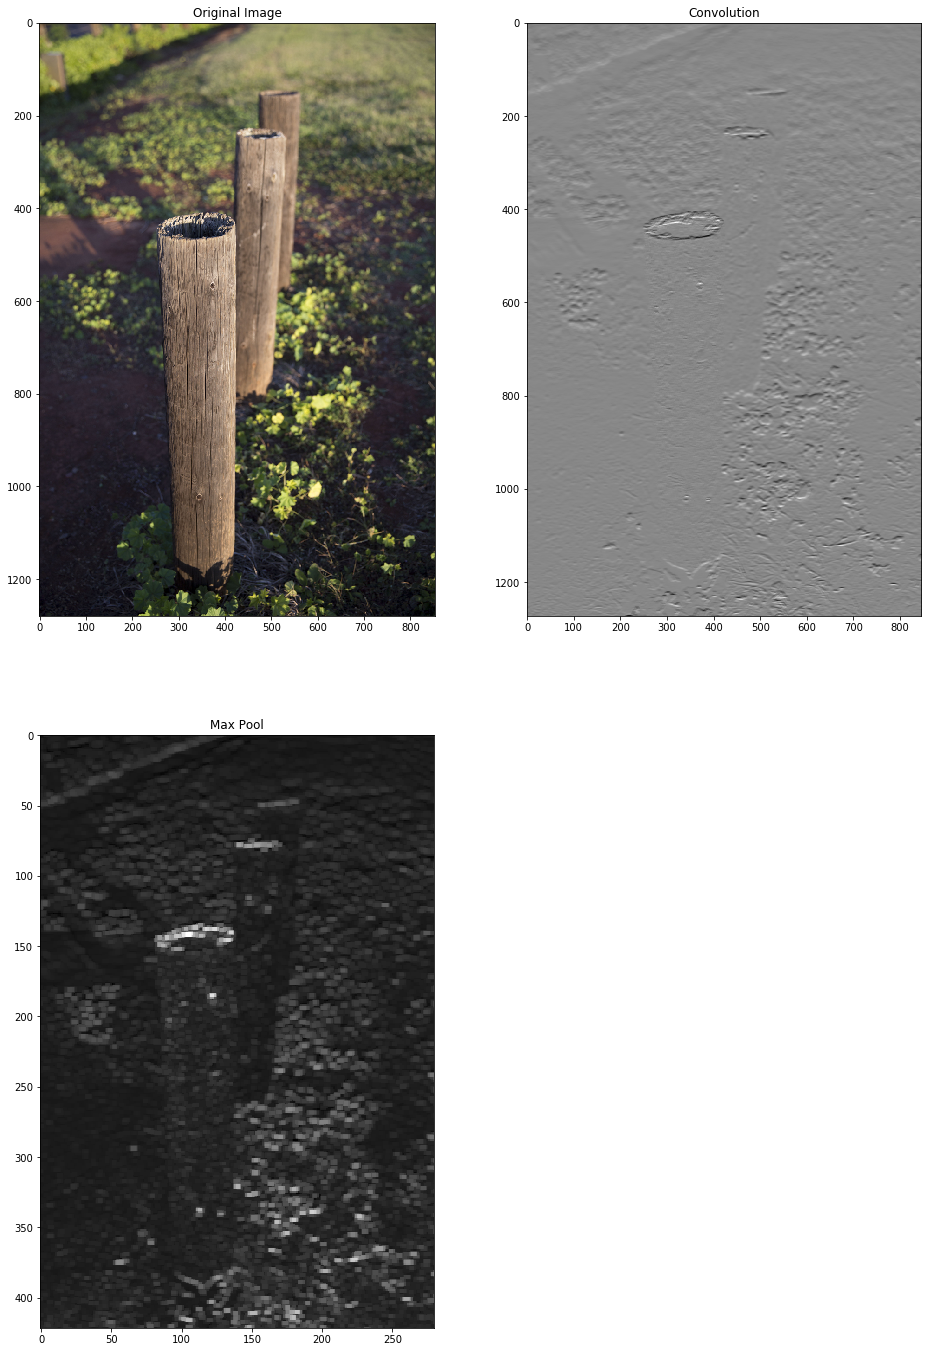

In [12]:
show_conv_b4_after('data/hawaii_1.jpg', conv_filter_horizontal, pooling_size=filter_size, pooling_stride=3)

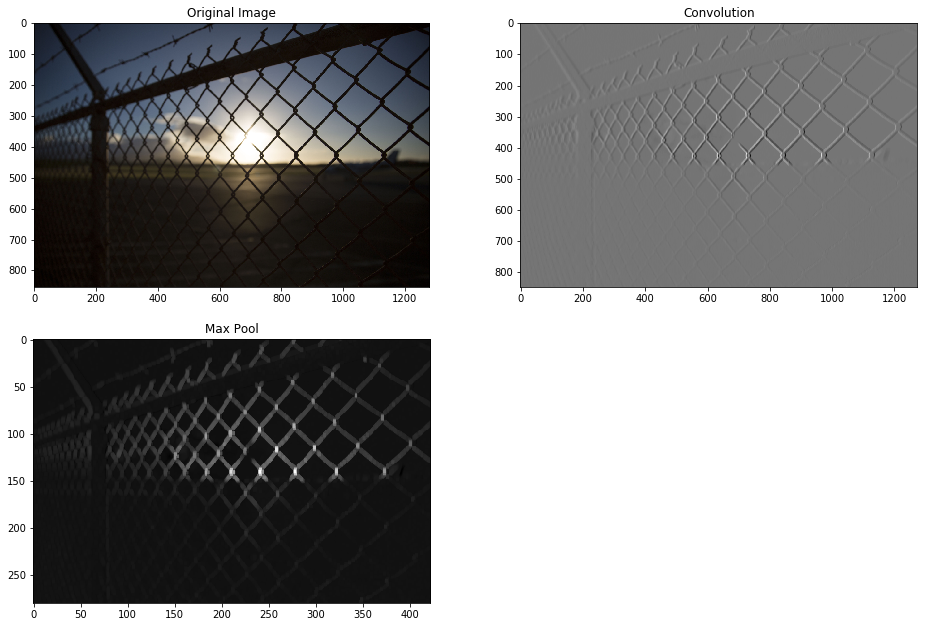

In [13]:
show_conv_b4_after('data/hawaii_2.jpg', conv_filter_vertical, pooling_size=filter_size, pooling_stride=3)

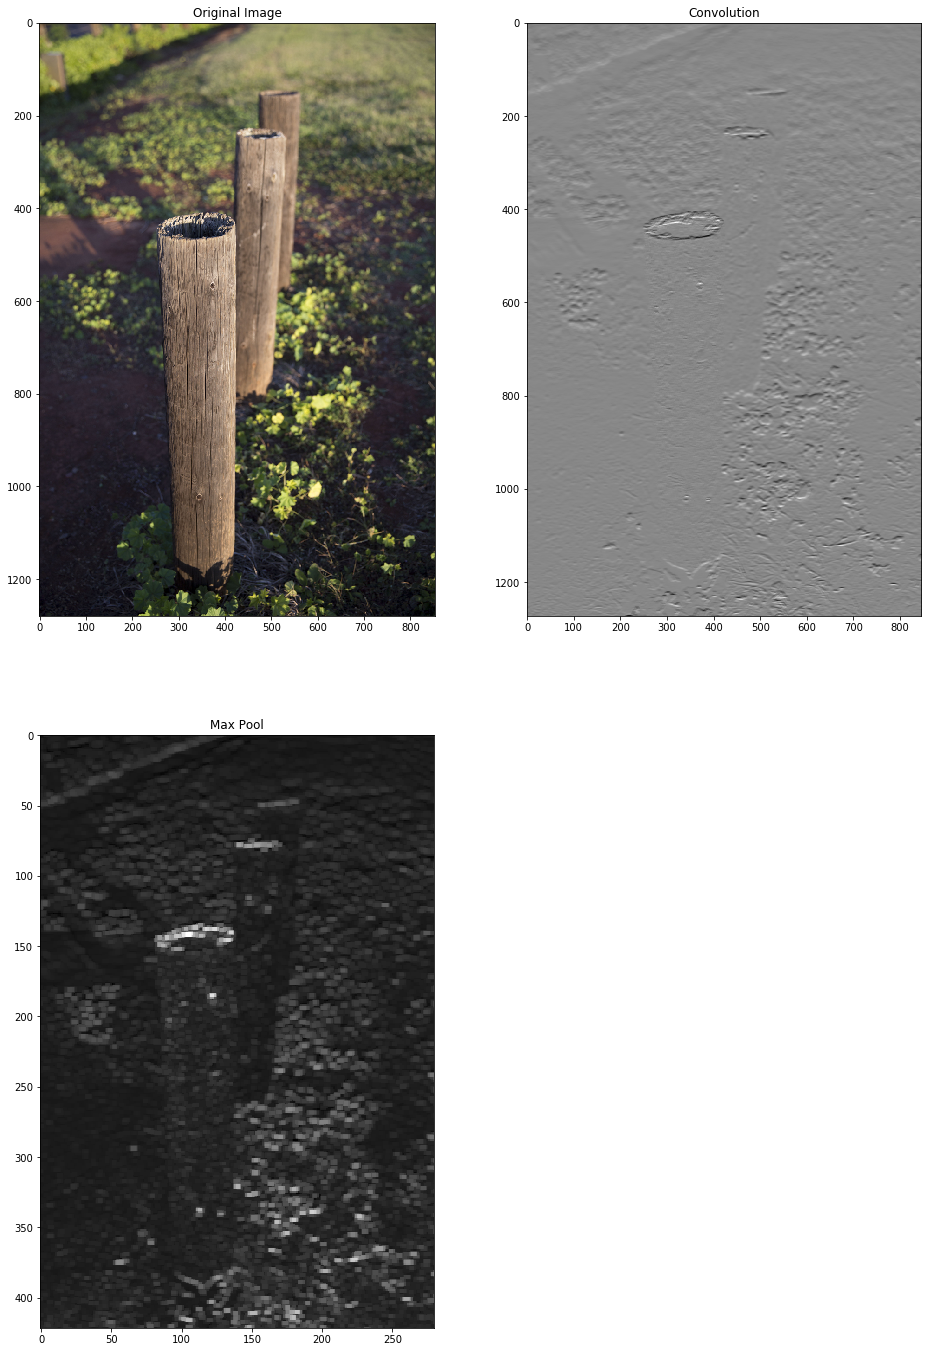

In [14]:
show_conv_b4_after('data/hawaii_1.jpg', conv_filter_horizontal, pooling_size=filter_size, pooling_stride=3)

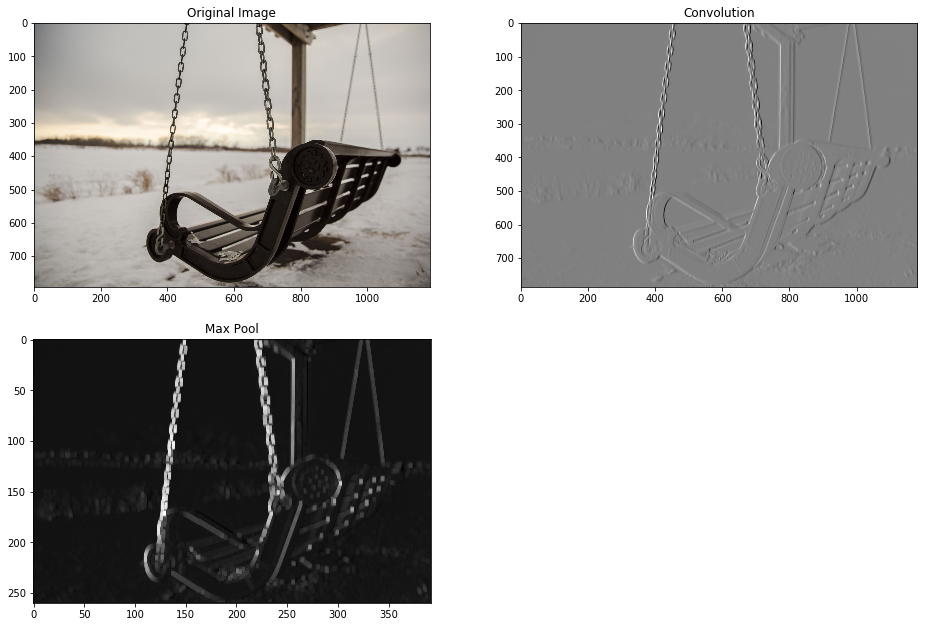

In [15]:
show_conv_b4_after('data/ada_hayden_1.jpg', conv_filter_vertical, pooling_size=filter_size, pooling_stride=3)

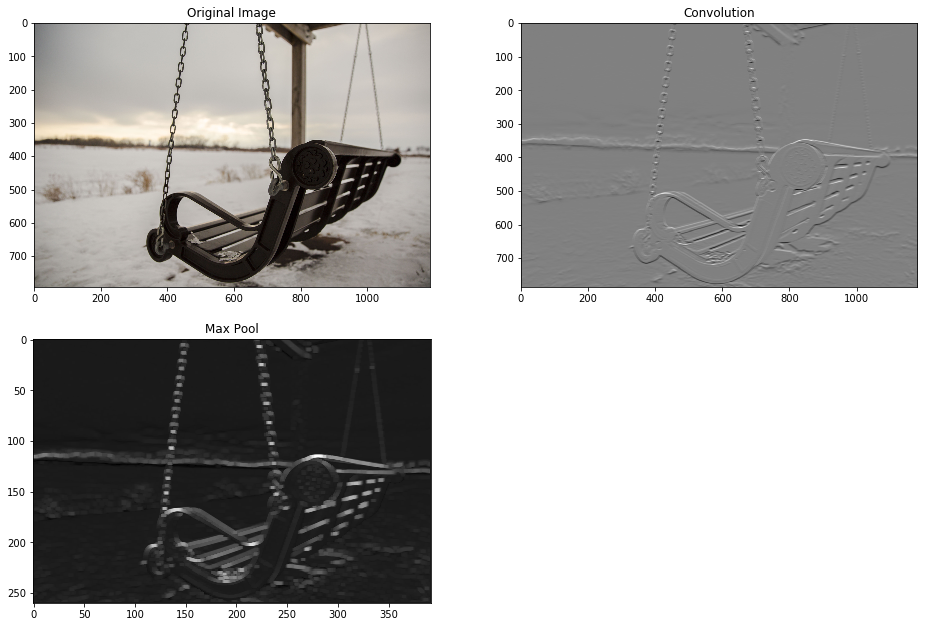

In [16]:
show_conv_b4_after('data/ada_hayden_1.jpg', conv_filter_horizontal, pooling_size=filter_size, pooling_stride=3)